# 6002 Project

### Antoniadis Christoforos , Kontoudakis Nikolaos, Tsamoura Evgenia 

In [3]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from itertools import product
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from typing import List
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set()

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.naive_bayes import BernoulliNB

warnings.filterwarnings('ignore')

In [4]:
# change the following on your pc!
projectPath = "/home/nikos/Documents/6002_project"
# projectPath = "C:/Users/Chris/Downloads"
dataPath = projectPath + "/smp500.csv"

In [5]:
smp500 = pd.read_csv(dataPath, sep= ',', header= 0, names=["date",	"open",	"high",	"low", "close",	"adj. close", "volume"])
smp500 = smp500.drop(columns = ["adj. close"])
smp500['date'] = pd.to_datetime(smp500['date'])
# set date as key
# smp500= smp500.set_index(smp500['date']).to_period('M').drop(columns='date')
smp500= smp500.set_index(smp500['date']).to_period('D').rename(columns = {'date': 'dateString'})
smp500

,dateString,open,high,low,close,volume
date,,,,,,
2024-11-29,2024-11-29,6003.98,6044.17,6003.98,6032.38,2444420000
2024-11-27,2024-11-27,6014.11,6020.16,5984.87,5998.74,3363340000
2024-11-26,2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000
2024-11-25,2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000
2024-11-22,2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000
...,...,...,...,...,...,...
2022-01-07,2022-01-07,4697.66,4707.95,4662.74,4677.03,4181510000
2022-01-06,2022-01-06,4693.39,4725.01,4671.26,4696.05,4295280000
2022-01-05,2022-01-05,4787.99,4797.70,4699.44,4700.58,4887960000


### Data validation

In [7]:
print("There are %s na values" %(smp500.isna().sum().sum()))
print("There are %s zero values" % (smp500[smp500 == 0].sum(numeric_only=True).sum()))

# Check inconsistencies
# at every row low must be the lowest value
print("There are %s rows that the low of the row is higher than any other value" % (smp500[(smp500.low> smp500.high) & (smp500.low> smp500.close) & (smp500.low > smp500.open)].sum(numeric_only=True).sum()))

There are 0 na values
There are 0.0 zero values
There are 0.0 rows that the low of the row is higher than any other value


### Outlier Detection

In [9]:
#check the values of each row per specific column for outliers
def identifyOutliers(columnName):
    Zsmp500 = (smp500[columnName] - np.mean(smp500[columnName])) / np.std(smp500[columnName])
    return Zsmp500[(Zsmp500 > 3 ) | (Zsmp500 < -3 )].index
    
# run the function for every column
# smp500= smp500.drop(removeOutliers('open'), axis= 0).drop(removeOutliers('high'), axis= 0).drop(removeOutliers('low'), axis= 0).drop(removeOutliers('close'), axis= 0).drop(removeOutliers('volume'), axis= 0)
identifyOutliers('volume')

PeriodIndex(['2024-09-20', '2024-06-28', '2024-06-21', '2024-03-15',
             '2023-12-15', '2023-09-15', '2023-06-16', '2023-03-17',
             '2022-12-16', '2022-09-16', '2022-06-24', '2022-06-17',
             '2022-05-31', '2022-03-18', '2022-03-08', '2022-03-07',
             '2022-02-24', '2022-01-24'],
            dtype='period[D]', name='date')

### Ploting

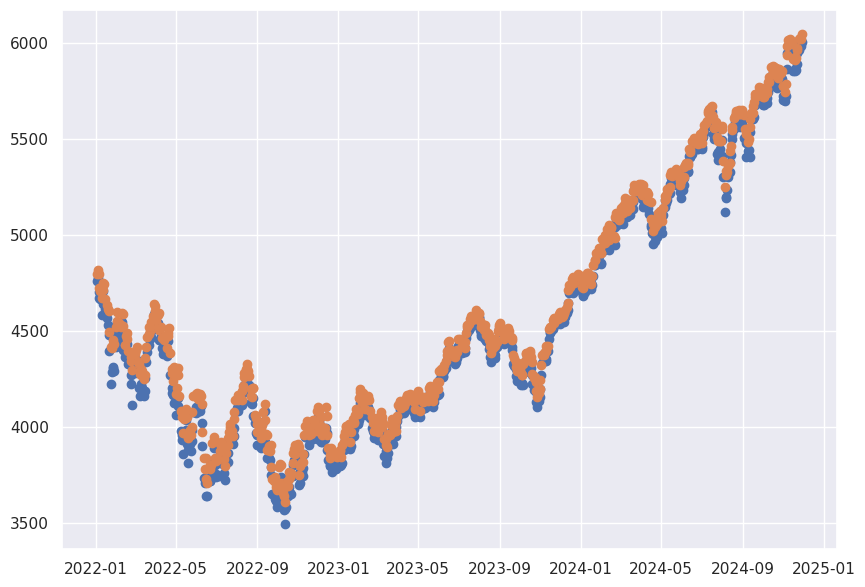

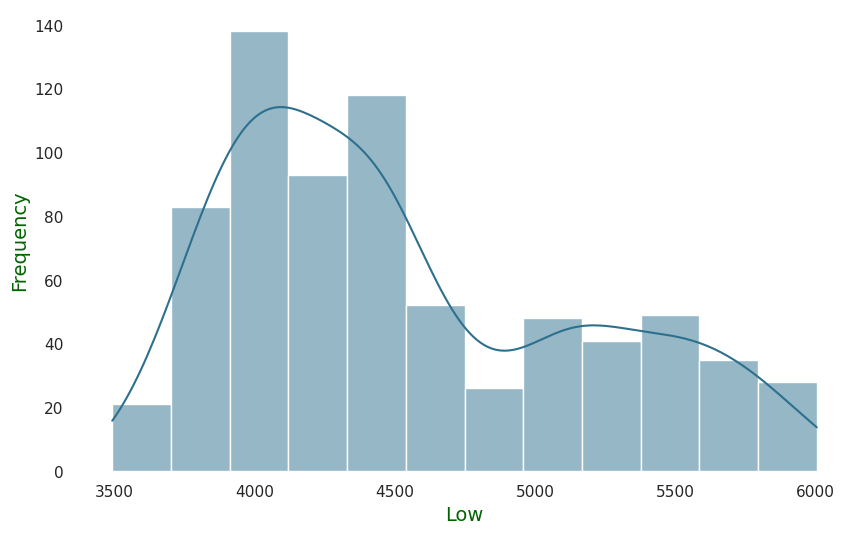

In [11]:
#scater plot
plt.figure(figsize=(10, 7))
plt.scatter(y= smp500.low, x =smp500.index.to_timestamp())
plt.scatter(y= smp500.high, x =smp500.index.to_timestamp())

# histogram
sns.set(style="white")
colors = sns.color_palette("viridis", n_colors=10)

# plotting the SAT score distribution using Seaborn with a KDE (Kernel Density Estimate) plot
plt.figure(figsize=(10, 6))
# sns.histplot(smp500.open, kde=True, color=colors[0])
# sns.histplot(smp500.close, kde=True, color=colors[1])
# sns.histplot(smp500.high, kde=True, color=colors[2])
sns.histplot(smp500.low, kde=True, color=colors[3])
# sns.histplot(smp500.volume, kde=True, color=colors[3])

# Remove left and bottom spines to eliminate the box
sns.despine(left=True, bottom=True)

# set the title and labels
# plt.title("SAT Score Distribution", fontsize=18, color='darkgreen')
plt.xlabel("Low", fontsize=14, color='darkgreen')
plt.ylabel("Frequency", fontsize=14, color='darkgreen')


# display the plot
plt.show()

# Q2

### Naive Aproach

In [14]:
# group by month
monthly_summary = smp500.drop(columns = ['volume']).groupby(smp500.index).mean()
predictions = monthly_summary[(monthly_summary.index >= '2022-01') & (monthly_summary.index < '2022-02')].drop(columns = 'dateString').mean()
firstMonth = monthly_summary[(monthly_summary.index >= '2022-01') & (monthly_summary.index < '2022-02')].drop(columns = 'dateString')

# predictions = predictions.reset_index(drop=True)
data = smp500.drop(columns = 'volume')[smp500.index >= '2022-02']
first_year = monthly_summary[(monthly_summary.index >= '2022-01')&(monthly_summary.index < '2023-01')]
# repeat the row to match the size of the test data
repeated_naiveResult = pd.DataFrame([predictions] * len(first_year), columns=first_year.drop(columns = 'dateString').columns, index=first_year.index)

# MAE = np.abs(monthly_summary - repeated_naiveResult).mean().mean()
# MSE2 = mean_squared_error(monthly_summary.high, repeated_naiveResult.high)
# manual calculation for every column

MSE = ((first_year.drop(columns = 'dateString') - repeated_naiveResult)**2).sum(axis=0)/len(first_year)
MAD = np.abs((first_year.drop(columns = 'dateString') - repeated_naiveResult)).sum(axis=0)/len(first_year)
print(MSE)
print(MAD)
#data.to_csv("rawdata.csv", sep=',', encoding='utf-8', index=True, header=True)
#repeated_naiveResult.to_csv("repeatednaiveresult.csv", sep=',', encoding='utf-8', index=True, header=True

open     320743.474084
high     319404.238819
low      302741.215827
close    310736.374268
dtype: float64
open     496.219932
high     494.675817
low      480.515060
close    487.144317
dtype: float64


### Rolling window

In [16]:
# first_year.sort_index(ascending = True, inplace=True)


In [17]:
#We compute a fast moving average of 5 days (MA40) and a slow moving average of 20 days on the close price.
data = firstMonth.copy()

MAS = 5
MAF = 20
data['rolling_low_mean'] = data['low'].rolling(window=MAS).mean()
data['rolling_low_mean_fast'] = data['low'].rolling(window=MAF).mean()

# predict the next 11 month. About 20 days
predicted_values = []
last_window = data['low'].iloc[-MAS:].tolist()

for _ in range(220):
    # Calculate the mean of the current window
    next_prediction = sum(last_window) / MAS
    predicted_values.append(next_prediction)
    last_window.pop(0)
    last_window.append(next_prediction)  

# Create a DataFrame for predictions
future_dates = pd.date_range(start='2022-02-01', periods=220, freq='B')  # Business days
predictions = pd.DataFrame({'date': future_dates, 'predicted_low': predicted_values}).set_index('date')


# predict the next 11 month. About 20 days
predicted_values_fast = []
last_window_fast = data['low'].iloc[-MAF:].tolist()

for _ in range(220):
    next_prediction_fast = sum(last_window_fast) / MAF
    predicted_values_fast.append(next_prediction_fast)
    
    last_window_fast.pop(0)
    last_window_fast.append(next_prediction_fast)

future_dates_fast = pd.date_range(start='2022-02-01', periods=220, freq='B')
predictions_fast = pd.DataFrame({'date': future_dates, 'predicted_low_fast': predicted_values_fast}).set_index('date')





# Display predictions
print(predictions)
print(predictions_fast)

            predicted_low
date                     
2022-02-01    4321.578000
2022-02-02    4328.471600
2022-02-03    4333.205920
2022-02-04    4337.947104
2022-02-07    4347.044525
...                   ...
2022-11-29    4337.676667
2022-11-30    4337.676667
2022-12-01    4337.676667
2022-12-02    4337.676667
2022-12-05    4337.676667

[220 rows x 1 columns]
            predicted_low_fast
date                          
2022-02-01         4528.042000
2022-02-02         4516.535600
2022-02-03         4503.648880
2022-02-04         4493.859324
2022-02-07         4484.989290
...                        ...
2022-11-29         4442.418571
2022-11-30         4442.418571
2022-12-01         4442.418571
2022-12-02         4442.418571
2022-12-05         4442.418571

[220 rows x 1 columns]


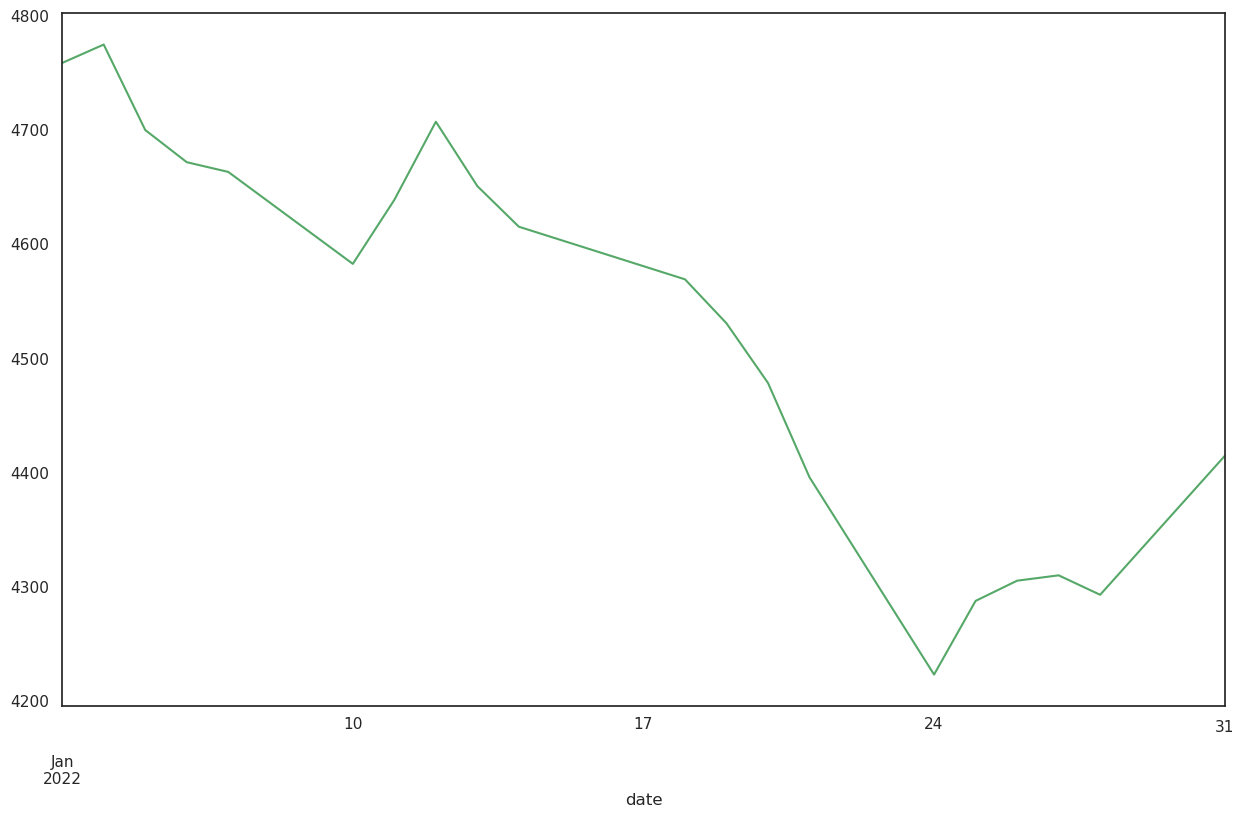

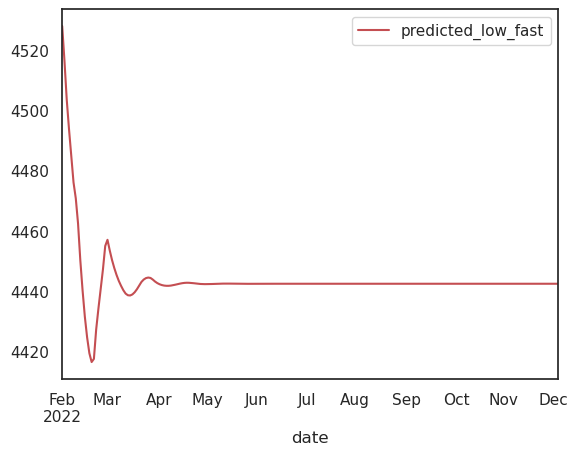

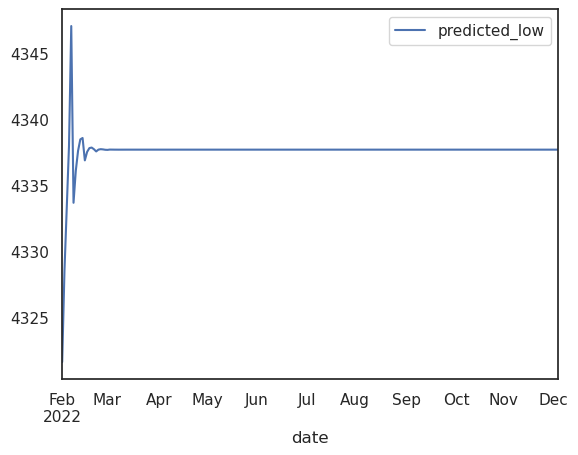

In [18]:
plt.figure(figsize= (15,9))
data['low'].plot(color = 'g', label = 'Low Price')
predictions_fast.plot(color = 'r', label = 'MA{}'.format(MAF) )
predictions.plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()

### Exponential Smoothing

### 1.0 Simple Exponential Smoothing

In [29]:
# Apply Simple Exponential Smoothing
alpha = 0.15
ses_model = SimpleExpSmoothing(data['low']).fit(smoothing_level=alpha, optimized=False)
# Forecast for the next 10 periods
forecast = ses_model.forecast(11)
print(forecast)

2022-02-01    4418.778335
2022-02-02    4418.778335
2022-02-03    4418.778335
2022-02-04    4418.778335
2022-02-05    4418.778335
2022-02-06    4418.778335
2022-02-07    4418.778335
2022-02-08    4418.778335
2022-02-09    4418.778335
2022-02-10    4418.778335
2022-02-11    4418.778335
Freq: D, dtype: float64


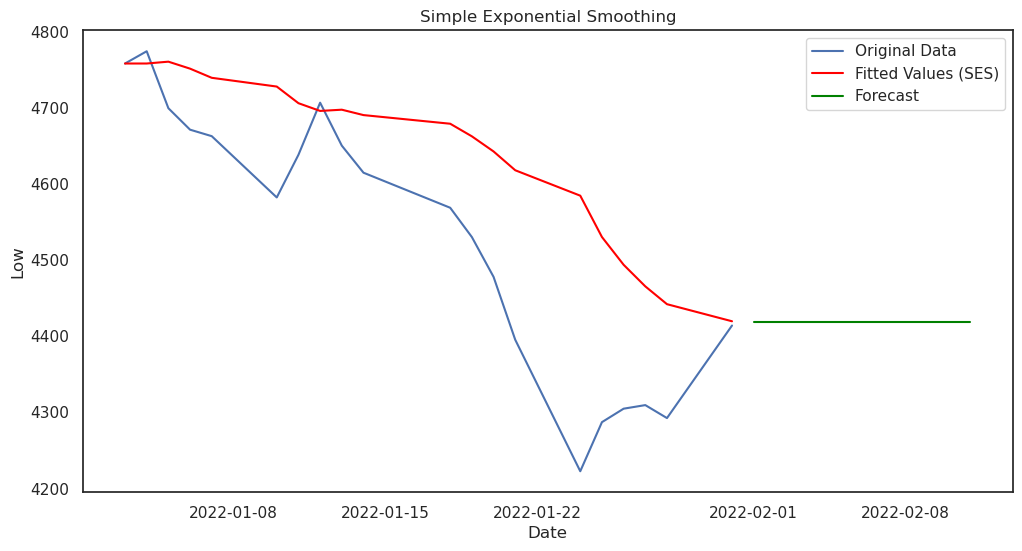

In [31]:
# Plot the original data and the forecast

plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['low'], label='Original Data')
plt.plot(ses_model.fittedvalues, label='Fitted Values (SES)', color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.show()

### Double Exponential Smoothing

In [34]:
# Perform double exponential smoothing
#Source: https://vbatopandas.blogspot.com/2023/12/how-to-use-statsmodels-library-in.html
model = sm.tsa.ExponentialSmoothing(data['low'], trend='add')
des_model = model.fit(smoothing_level=0.3, smoothing_slope=0.2)
data['Forecast'] = des_model.fittedvalues

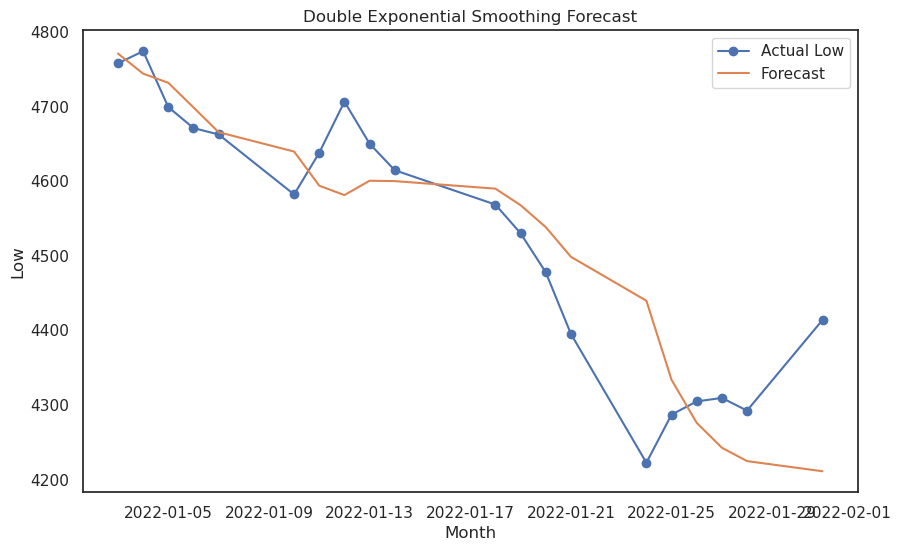

In [36]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data.index.to_timestamp(), data['low'], label='Actual Low', marker='o')
plt.plot(data['Forecast'], label='Forecast')
plt.xlabel('Month')
plt.ylabel('Low')
plt.title('Double Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Holt's Linear Trend Model

In [39]:
# Apply Holt's Linear Trend Model
# Source: https://www.statology.org/how-to-apply-exponential-smoothing-to-time-series-data-in-python/
holt_model = ExponentialSmoothing(data['low'], trend='add').fit()

# Forecast for the next 10 periods
forecast_holt = holt_model.forecast(10)

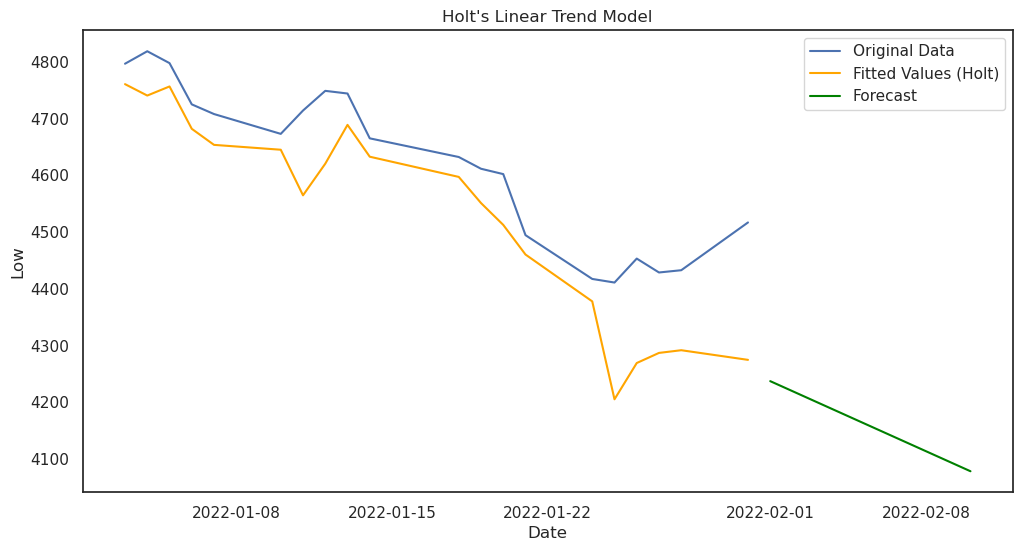

In [41]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['high'], label='Original Data')
plt.plot(holt_model.fittedvalues, label='Fitted Values (Holt)', color='orange')
plt.plot(forecast_holt, label='Forecast', color='green')
plt.title("Holt's Linear Trend Model")
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.show()

### Holt Winter’s Exponential Smoothing (HWES)

In [44]:
data = data.copy()
#data['date'] = pd.to_datetime(data['date'])

In [94]:
# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]


def plot_func(forecast1: List[float],
              forecast2: List[float],
              forecast3: List[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index.to_timestamp(), y=train['low'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=test['low'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test.index.to_timestamp(), y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Low Volume')
    return fig.show()

In [96]:
# Fit simple model and get forecasts
print(train['low'])
train = train.sort_index()
model_simple = SimpleExpSmoothing(train['low']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

date
2022-01-03    4758.17
2022-01-04    4774.27
2022-01-05    4699.44
2022-01-06    4671.26
2022-01-07    4662.74
2022-01-10    4582.24
2022-01-11    4638.27
2022-01-12    4706.71
2022-01-13    4650.29
2022-01-14    4614.75
2022-01-18    4568.70
2022-01-19    4530.20
2022-01-20    4477.95
2022-01-21    4395.34
2022-01-24    4222.62
2022-01-25    4287.11
Freq: D, Name: low, dtype: float64


In [98]:
# Fit Holt's model and get forecasts
model_holt = Holt(train['low'], damped=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))

In [100]:
# Fit Holt Winters model and get forecasts
model_holt_winters = ExponentialSmoothing(
    train['low'], trend='mul', seasonal='mul', seasonal_periods=7, initialization_method='estimated'
).fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test))

In [102]:
print(model_holt_winters.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      low   No. Observations:                   16
Model:             ExponentialSmoothing   SSE                          59457.312
Optimized:                         True   AIC                            153.527
Trend:                   Multiplicative   BIC                            162.025
Seasonal:                Multiplicative   AICC                           335.527
Seasonal Periods:                     7   Date:                 Fri, 06 Dec 2024
Box-Cox:                          False   Time:                         23:54:41
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8182143                alpha                 True
smoothing_trend          

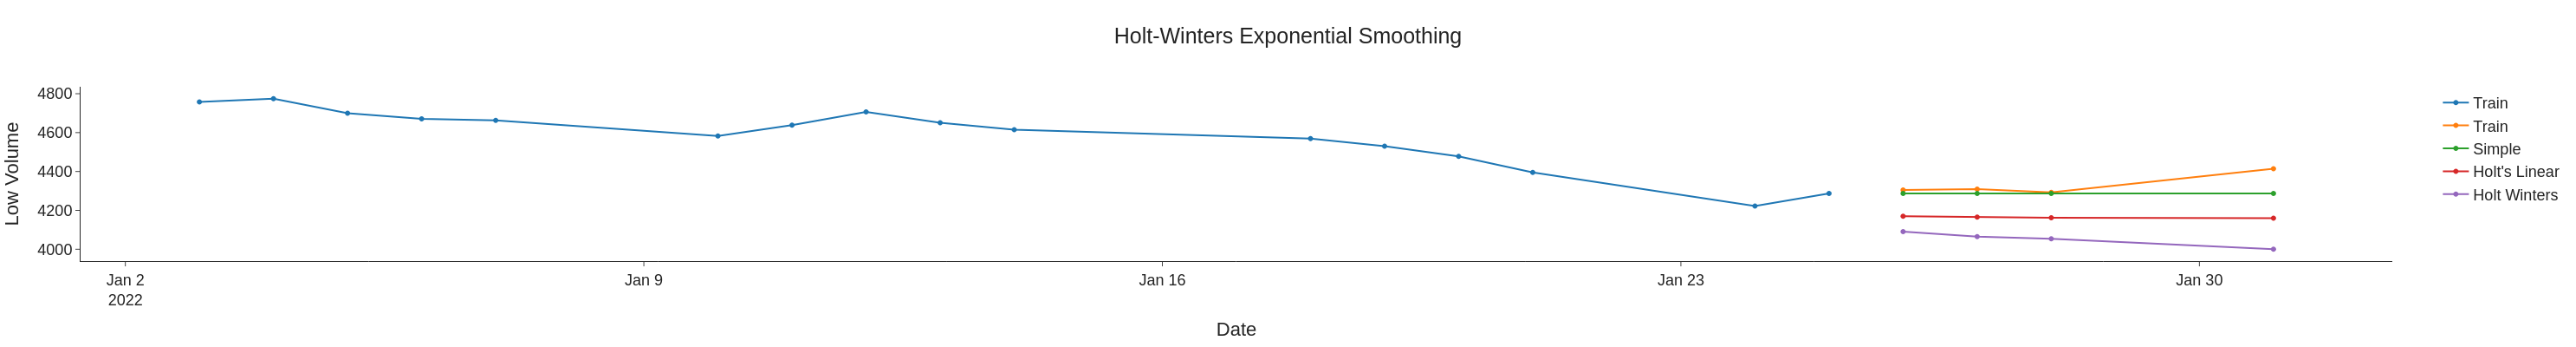

In [104]:
# Plot the forecasts
plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters,  "Holt-Winters Exponential Smoothing")